# Logit Likelihood

## imports

In [1]:
import matplotlib.pyplot as plt

import math

import numpy as np
import pandas as pd

from time import time

from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

## Simulate Data

In [2]:
#####################################
### simulate data
## p(y=1|x) = F(beta[1] + beta[2]x), y ~ Bern(py1), F(x) = exp(x)/(1+exp(x))

n=500 #sample size
beta = (1,.5) # true (intercept, slope)

##set seed
np.random.seed(34)

## draw x ~ N(0,1)
x = np.random.randn(n)

## sort x to make plotting better
x = np.sort(x)

## compute prob Y=1|x
py1 = 1/(1+np.exp(-(beta[0] + beta[1] * x)))

## storage for simulation results
y = np.zeros(n,dtype='int')

## simulate y and compute py1
for i in range(n):
    y[i] = np.random.binomial(1,py1[i])


## Sumarize and Plot

In [3]:
## pandas data frame
#In python, unlike R, there is no option to represent categorical data as factors.
ddf = pd.DataFrame({'x':x,'py1':py1,'y':y})
print(ddf.head())
ddf.describe()

          x       py1  y
0 -2.809924  0.400121  0
1 -2.765588  0.405453  0
2 -2.705108  0.412763  0
3 -2.683300  0.415409  0
4 -2.563626  0.430009  1


x         py1          y
count  500.000000  500.000000  500.00000
mean    -0.026167    0.718660    0.75400
std      0.975271    0.096395    0.43111
min     -2.809924    0.400121    0.00000
25%     -0.623134    0.665618    1.00000
50%     -0.049129    0.726202    1.00000
75%      0.651016    0.790097    1.00000
max      2.479618    0.903768    1.00000

Text(0.5, 0, 'x')

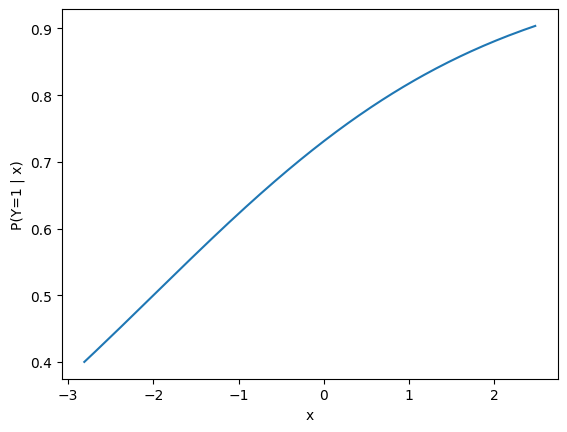

In [4]:
# x vs p(y=1|x)
plt.plot(x,py1)
plt.ylabel('P(Y=1 | x)'); plt.xlabel('x')

In [5]:
## marginal of y
print(ddf['y'].value_counts()/n)

y
1    0.754
0    0.246
Name: count, dtype: float64


<Axes: title={'center': 'x'}, xlabel='y'>

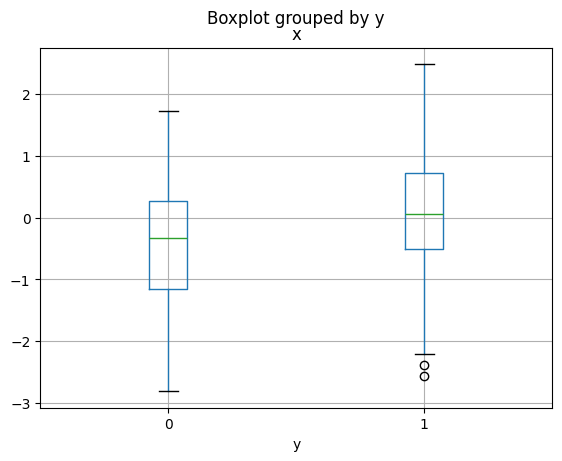

In [6]:
## x|y
ddf.boxplot(column=['x'],by='y')

Text(0, 0.5, 'jittered y')

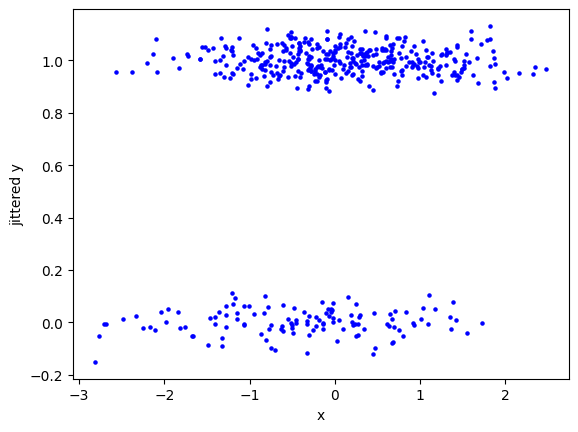

In [7]:
## y|x with jitter
plt.scatter(x,y+np.random.randn(n)*.05,s=5.0,color='blue')
plt.xlabel('x'); plt.ylabel('jittered y')

Text(0.5, 0, 'x')

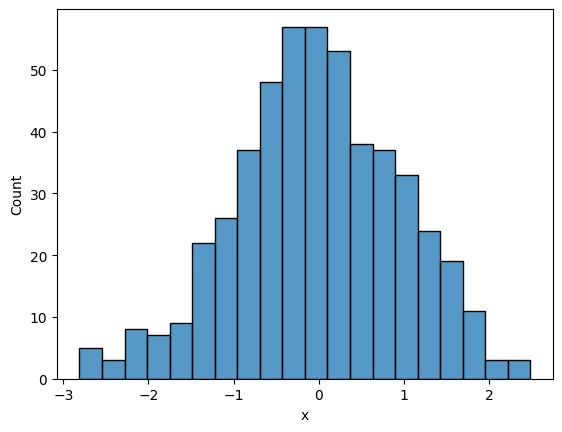

In [8]:
## marginal of x
import seaborn as sns
p = sns.histplot(x,bins=20)
p.set_xlabel('x')

## Fit Logit with sklearn and statsmodels

In [9]:
#sklearn
lfit = LogisticRegression(penalty=None)
# need numpy 2dim array for X
X = x.reshape((n,1)).copy()
lfit.fit(X,y)
print(lfit.intercept_,lfit.coef_)

[1.20543896] [[0.55728805]]


In [10]:
#statsmodels
XX = sm.add_constant(X)
lfit2 = sm.Logit(y, XX).fit()
print(lfit2.summary())

Optimization terminated successfully.
         Current function value: 0.532016
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  500
Model:                          Logit   Df Residuals:                      498
Method:                           MLE   Df Model:                            1
Date:                Wed, 05 Feb 2025   Pseudo R-squ.:                 0.04639
Time:                        18:57:33   Log-Likelihood:                -266.01
converged:                       True   LL-Null:                       -278.95
Covariance Type:            nonrobust   LLR p-value:                 3.629e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2054      0.111     10.868      0.000       0.988       1.423
x1             0.5573      0.

Text(0.5, 1.0, 'x vs. p(Y=1 | x)')

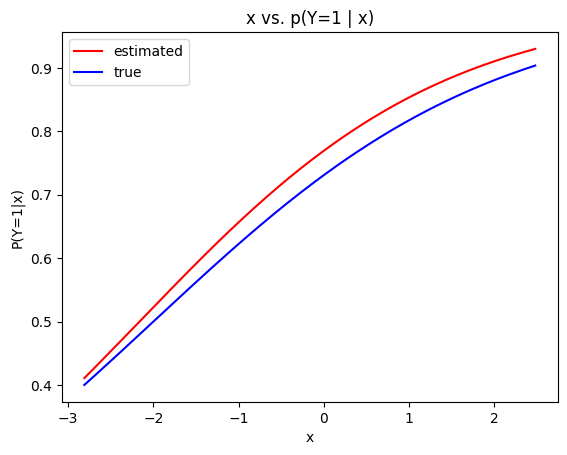

In [11]:
# plot fit
phat = lfit2.predict(XX) # from statsmodels !!
plt.plot(X,phat,c='red')
plt.xlabel('x'); plt.ylabel('P(Y=1|x)')
plt.plot(X,py1,c='blue')
plt.legend(['estimated','true'])
plt.title('x vs. p(Y=1 | x)')

In [12]:
#check fits are the same from sklearn and statsmodels
temp = lfit.predict_proba(X)[:,1]  #notice the proba!!
pd.Series(temp - phat).describe()

count    5.000000e+02
mean     1.384802e-08
std      1.286006e-08
min     -3.929415e-08
25%      9.424430e-09
50%      1.791216e-08
75%      2.359847e-08
max      2.518051e-08
dtype: float64

## Compute Likelihood

In [13]:
### - log lik
def mLL1(x,y,beta):
   ''' function to compute minus log likelihood for a simple logit'''
   n = len(y)
   mll = 0.0
   for i in range(n):
      py1 = 1/(1 + math.exp(-(beta[0] + beta[1]*x[i])))
      if (y[i] == 1):
         mll -= math.log(py1)
      else:
         mll -= math.log(1-py1)
   return(mll)

##check, compute - log like at mle and see that you can the same thing as statsmodels
bmle = (lfit.intercept_[0],lfit.coef_[0][0])
temp = mLL1(x,y,bmle)
print(f'minus log Lik from mLL1 is {temp:0.4f}')

minus log Lik from mLL1 is 266.0079


Agrees with statsmodels !!

In [14]:
##################################################
### get -LL on beta1 grid
nval = 1000
p = 2
bMat = np.zeros((nval,p))
bMat[:,0] = lfit.intercept_
bMat[:,1] = np.linspace(0,1,nval)
llv = np.zeros(nval)

for i in range(nval):
   llv[i] = mLL1(x,y,bMat[i,:])

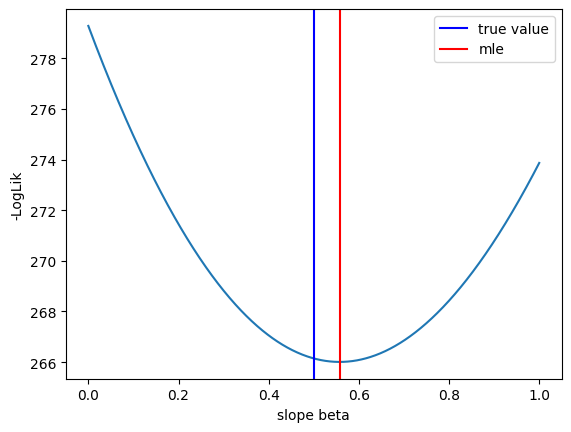

In [15]:
## plot
ii = llv.argmin()
plt.plot(bMat[:,1],llv)
plt.axvline(beta[1],c='blue',label='true value')
plt.axvline(bMat[ii,1],c='red',label='mle')
plt.xlabel('slope beta'); plt.ylabel('-LogLik')
plt.legend()

In [16]:
## row of bMat at min:
print(f'bhat from grid: {bMat[ii,:]}')
## check
print(f'bhat from sklearn: {lfit.intercept_}, {lfit.coef_[0]}')

bhat from grid: [1.20543896 0.55755756]
bhat from sklearn: [1.20543896], [0.55728805]


In [17]:
## bivariate grid

## make 2dim grid as numpy array
nval = 100
b0g = np.linspace(0,2,nval) #intercept grid
b1g = np.linspace(0,1,nval) #slope grid
bb0, bb1 = np.meshgrid(b0g,b1g)
bbM = np.hstack([bb0.reshape((nval*nval,1)),bb1.reshape((nval*nval,1))])
nn = bbM.shape[0]

print("dim of bivariate grid:",bbM.shape)

## make 2dim grid as pandas data frame
bbD = pd.DataFrame(bbM)

dim of bivariate grid: (10000, 2)


In [18]:
## time using DataFrame
t1 = time()
llv1 = np.zeros(nn)
for i in range(nn):
   if((i % 1000) == 0):
      print(i,', ',nn)
   llv1[i] = mLL1(x,y,bbD.iloc[i,:])
t2 = time()
print("time: ",t2-t1)

0 ,  10000
1000 ,  10000
2000 ,  10000
3000 ,  10000
4000 ,  10000
5000 ,  10000
6000 ,  10000
7000 ,  10000
8000 ,  10000
9000 ,  10000
time:  14.806827306747437


In [19]:
## time numpy array 
llv2 = np.zeros(nn)
# time loop
t1 = time()
for i in range(nn):
   llv2[i] = mLL1(x,y,bbM[i,:])
t2 = time()
print("time: ",t2-t1)

time:  2.656773805618286


In [20]:
## check got the same thing
pd.Series(llv1-llv2).describe()
print("abs diff:",np.abs(llv1-llv2).max())

abs diff: 0.0


## Now vectorize the mll computation

In [21]:
#### vectorize
def mLL(x,y,beta):
   py1 = 1.0/(1.0 + np.exp(-(beta[0] + beta[1]*x)))
   return(-(y * np.log(py1) + (1-y) * np.log(1-py1)).sum())

In [22]:
## time the loop
llv3 = np.zeros(nn)
t1 = time()
for i in range(nn):
   llv3[i] = mLL(x,y,bbM[i,:])
t2 = time()
print("time: ",t2-t1)

time:  0.13895368576049805


In [23]:
## check same
print("abs diff:",np.abs(llv2-llv3).max())

abs diff: 3.637978807091713e-12


## look at llv

In [24]:
# get min
ii = llv3.argmin()
print(bbM[ii,:])
print(lfit.intercept_,lfit.coef_)

[1.21212121 0.55555556]
[1.20543896] [[0.55728805]]


Text(0, 0.5, 'beta1')

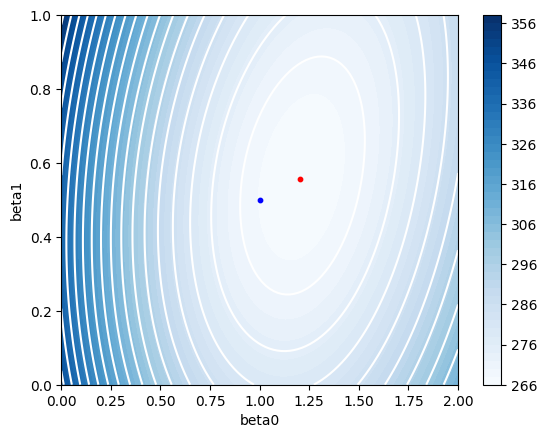

In [25]:
llM = llv3.reshape((nval,nval))

## contour plot
plt.contourf(bb0,bb1,llM,50,cmap='Blues')
plt.colorbar()
plt.contour(bb0,bb1,llM,20,colors='white')
plt.scatter(bmle[0],bmle[1],c='red',s=10)
plt.scatter(beta[0],beta[1],c='blue',s=10)
plt.xlabel('beta0')
plt.ylabel('beta1')

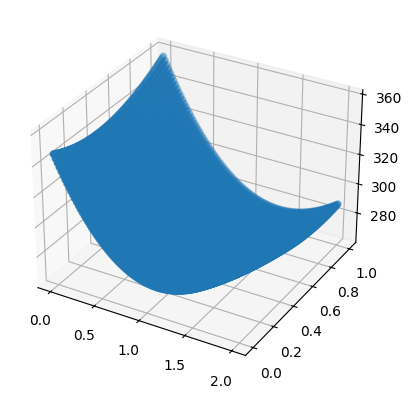

In [26]:
## 3D scatter
ax = plt.axes(projection='3d')
ax.scatter3D(bbM[:,0],bbM[:,1],llv3)

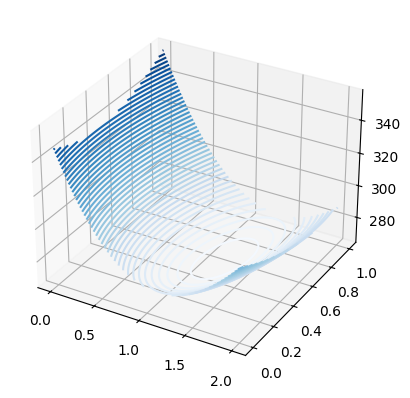

In [27]:
## 3D contour
ax = plt.axes(projection='3d')
ax.contour3D(bb0,bb1,llM,50,cmap='Blues')

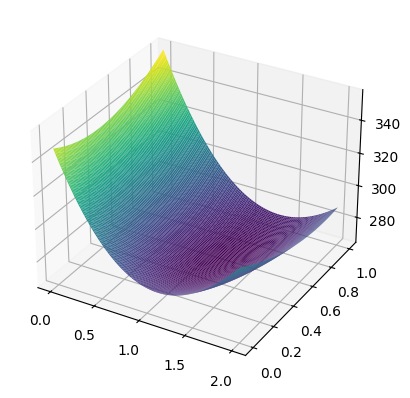

In [28]:
## plot surface
ax = plt.axes(projection='3d')
ax.plot_surface(bb0,bb1,llM,rstride=1,cstride=1,cmap='viridis',edgecolor='none')

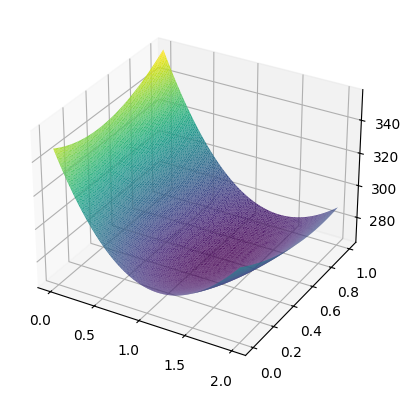

In [29]:
## plot trisurface
ax = plt.axes(projection='3d')
ax.plot_trisurf(bbM[:,0],bbM[:,1],llv3,cmap='viridis',edgecolor='none')